# Import Dependencies

In [300]:
# System
import os

# Data Analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

import tensorflow as tf

# Get Data

In [301]:
file_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/cutfree-simulations/runtime_data_v2.csv"
df_original = pd.read_csv(file_path)
df = df_original.copy()
df.iloc[0]

Oligo                        NNNNNN
OligoLength                       6
Sites                   Any["YATR"]
TotalSites                        1
SiteLength                        4
CutFree_Randomer             NBNVVN
CutFree_Degeneracy          7.45472
CutFree_Time               0.006211
CutFreeRL_Randomer           NNVVVN
CutFreeRL_Degeneracy        7.45472
CutFreeRL_Time             0.228063
Name: 0, dtype: object

In [302]:
df.loc[(df["OligoLength"] == 6) & (df["TotalSites"] == 1) & (df["SiteLength"] == 4)]

,Oligo,OligoLength,Sites,TotalSites,SiteLength,CutFree_Randomer,CutFree_Degeneracy,CutFree_Time,CutFreeRL_Randomer,CutFreeRL_Degeneracy,CutFreeRL_Time
0,NNNNNN,6,"Any[""YATR""]",1,4,NBNVVN,7.454720,0.006211,NNVVVN,7.454720,0.228063
1750,NNNNNN,6,"Any[""GATC""]",1,4,HNNNDD,7.454720,0.006383,NNNDDD,7.454720,0.225150
3500,NNNNNN,6,"Any[""GGCC""]",1,4,NHNNDN,7.742402,0.007255,NNNDND,7.742402,0.080954


# Data Classification

In [303]:
conditions = [
    (df["CutFree_Time"] <= df["CutFreeRL_Time"]),
    (df["CutFree_Time"] > df["CutFreeRL_Time"])
]

values = [0, 1] # 0 = CutFree, 1 = CutFreeRL

df["Algorithm"] = np.select(conditions, values)
df = df[["OligoLength", "TotalSites", "SiteLength", "Algorithm", "CutFree_Time", "CutFreeRL_Time"]]
df

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time
0,6,1,4,0,0.006211,0.228063
1,6,2,4,0,0.007820,0.087950
2,6,3,4,0,0.010071,0.136403
3,6,4,4,0,0.013531,0.150443
4,6,5,4,0,0.013882,0.183784
...,...,...,...,...,...,...
5244,40,6,8,1,12.737720,4.200124
5245,40,7,8,1,60.120769,3.009765
5246,40,8,8,1,60.379011,3.989743
5247,40,9,8,1,60.156297,3.611050


# Rejection Sampling

In [304]:
numCutFree = df[df.Algorithm == 0].shape[0]
print(numCutFree)

numCutFreeRL = df[df.Algorithm == 1].shape[0]
print(numCutFreeRL)

3731
1518


In [305]:
df_rejection = df[df.Algorithm == 0].sample(numCutFree-numCutFreeRL)
df = df.drop(df_rejection.index)
df

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time
4,6,5,4,0,0.013882,0.183784
5,6,6,4,0,0.011498,0.194223
6,6,7,4,0,0.018870,0.205003
7,6,8,4,0,0.019908,0.165705
8,6,9,4,0,0.069817,0.201999
...,...,...,...,...,...,...
5244,40,6,8,1,12.737720,4.200124
5245,40,7,8,1,60.120769,3.009765
5246,40,8,8,1,60.379011,3.989743
5247,40,9,8,1,60.156297,3.611050


In [306]:
numCutFree = df[df.Algorithm == 0].shape[0]
print(numCutFree)

numCutFreeRL = df[df.Algorithm == 1].shape[0]
print(numCutFreeRL)

1518
1518


In [307]:
df_total = df.copy()
df = df[["OligoLength", "TotalSites", "SiteLength", "Algorithm"]]

# Visualize Data

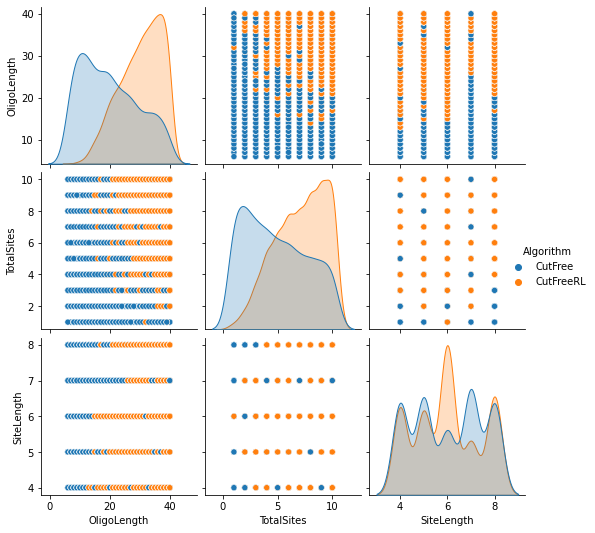

In [308]:
pair_plot = sns.pairplot(df, hue="Algorithm", diag_kind="kde")
new_labels = ["CutFree", "CutFreeRL"]
for t, l in zip(pair_plot._legend.texts, new_labels):
    t.set_text(l)
plt.show(pair_plot)

# Get Train/Test Split

In [309]:
x = df.drop(["Algorithm"], axis=1)
y = df["Algorithm"]

In [310]:
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x, y, test_size=0.2, random_state=100)
x_train_df.head()

,OligoLength,TotalSites,SiteLength
1395,33,6,8
4807,32,9,4
2512,21,3,5
956,25,7,4
599,17,10,8


In [311]:
y_train_df.head()

1395    1
4807    0
2512    0
956     0
599     0
Name: Algorithm, dtype: int32

In [312]:
x_train, y_train = tf.convert_to_tensor(x_train_df, dtype=tf.float32), tf.convert_to_tensor(y_train_df, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test_df, dtype=tf.float32), tf.convert_to_tensor(y_test_df, dtype=tf.float32)

In [313]:
x_train

<tf.Tensor: shape=(2428, 3), dtype=float32, numpy=
array([[33.,  6.,  8.],
       [32.,  9.,  4.],
       [21.,  3.,  5.],
       ...,
       [36.,  5.,  8.],
       [35.,  4.,  7.],
       [27., 10.,  7.]], dtype=float32)>

# Machine Learning

### Accuracy Function

In [314]:
def get_accuracy(pred, true):
    test_accuracy = accuracy_score(pred, true)*100
    print("Accuracy: {:.2f}%".format(test_accuracy))
    return test_accuracy

### MLP Classifier NN

In [315]:
class_NN = MLPClassifier(
    hidden_layer_sizes=(32, 32, 32, 32, 32),
    activation='tanh',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    max_iter=1000, 
    verbose=0,
    random_state=1)
class_NN.fit(x_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(32, 32, 32, 32, 32),
              learning_rate='adaptive', max_iter=1000, random_state=1,
              verbose=0)

In [316]:
y_pred = class_NN.predict(x_test)
get_accuracy(y_pred, y_test)
x_test

Accuracy: 82.07%


<tf.Tensor: shape=(608, 3), dtype=float32, numpy=
array([[30.,  8.,  8.],
       [39.,  8.,  5.],
       [13.,  6.,  8.],
       ...,
       [31.,  5.,  8.],
       [30.,  5.,  5.],
       [23.,  5.,  4.]], dtype=float32)>

### Grid Search to Find Optimal Parameters

In [317]:
params = {
    'hidden_layer_sizes' : [(64, 32, 32, 32, 16), (32, 32, 32, 32, 32)],
}

gscv = GridSearchCV(class_NN, params, verbose=1)

# gscv.fit(np.array(x_train), np.array(y_train))
# print(gscv.best_params_) 

### Analyze Results

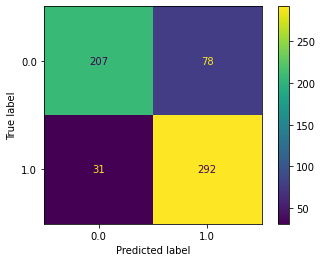

In [318]:
plot_confusion_matrix(class_NN, x_test, y_test)  
plt.show()

In [319]:
print(classification_report(y_pred, y_test, target_names=["CutFree", "CutFreeRL"]))

              precision    recall  f1-score   support

     CutFree       0.73      0.87      0.79       238
   CutFreeRL       0.90      0.79      0.84       370

    accuracy                           0.82       608
   macro avg       0.82      0.83      0.82       608
weighted avg       0.83      0.82      0.82       608



# Visualize Incorrect Classifications

In [320]:
df_total.head()

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time
4,6,5,4,0,0.013882,0.183784
5,6,6,4,0,0.011498,0.194223
6,6,7,4,0,0.018870,0.205003
7,6,8,4,0,0.019908,0.165705
8,6,9,4,0,0.069817,0.201999


In [321]:
df_total["Discrepency"] = df_total.CutFree_Time - df_total.CutFreeRL_Time
df_total = df_total.sort_values(by=["Discrepency"], ascending=True)
df_total.head()

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time,Discrepency
3339,37,10,7,0,0.632616,4.039638,-3.407021
3139,33,10,7,0,0.632100,3.728101,-3.096001
4988,35,10,7,0,0.531718,3.553635,-3.021917
5137,38,9,7,0,0.649197,3.664514,-3.015318
5238,40,10,7,0,0.919619,3.840002,-2.920383


In [322]:
df_total.loc[x_test_df.index[np.where(y_test_df != y_pred)], "Prediction"] = 0
df_total.loc[df_total["Prediction"].isna(), "Prediction"] = 1
df_total.head()

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time,Discrepency,Prediction
3339,37,10,7,0,0.632616,4.039638,-3.407021,1.0
3139,33,10,7,0,0.632100,3.728101,-3.096001,1.0
4988,35,10,7,0,0.531718,3.553635,-3.021917,1.0
5137,38,9,7,0,0.649197,3.664514,-3.015318,1.0
5238,40,10,7,0,0.919619,3.840002,-2.920383,1.0


In [323]:
df_total = df_total.reset_index(drop=True)
df_total.head()

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time,Discrepency,Prediction
0,37,10,7,0,0.632616,4.039638,-3.407021,1.0
1,33,10,7,0,0.632100,3.728101,-3.096001,1.0
2,35,10,7,0,0.531718,3.553635,-3.021917,1.0
3,38,9,7,0,0.649197,3.664514,-3.015318,1.0
4,40,10,7,0,0.919619,3.840002,-2.920383,1.0


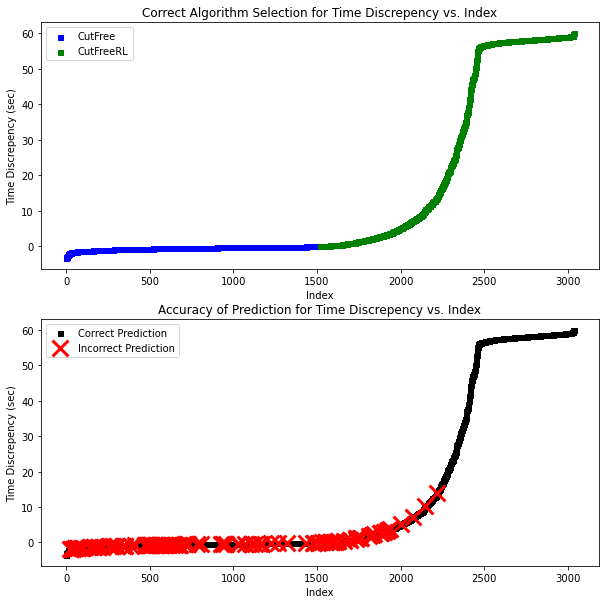

In [324]:
plt.figure(figsize=(10,10))

plt.subplot(211)
plt.scatter(
    df_total[df_total.Algorithm==0].index, df_total[df_total.Algorithm==0].Discrepency, 
    c ="blue",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total[df_total.Algorithm==1].index, df_total[df_total.Algorithm==1].Discrepency, 
    c ="green",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.title("Correct Algorithm Selection for Time Discrepency vs. Index")
plt.xlabel("Index")
plt.ylabel("Time Discrepency (sec)")
plt.legend(["CutFree", "CutFreeRL"])

plt.subplot(212)
plt.scatter(
    df_total[df_total.Prediction==1].index, df_total[df_total.Prediction==1].Discrepency, 
    c ="black",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total[df_total.Prediction==0].index, df_total[df_total.Prediction==0].Discrepency, 
    c ="red",
    linewidths = 3,
    marker ="x",
    s = 250)

plt.title("Accuracy of Prediction for Time Discrepency vs. Index")
plt.xlabel("Index")
plt.ylabel("Time Discrepency (sec)")
plt.legend(["Correct Prediction", "Incorrect Prediction"])
